#### SIGNATE 【練習問題】ワインの品種の予測
#### https://signate.jp/competitions/112

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.tsv',delimiter='\t' )
df_train.head()

,id,Y,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,3,12.36,3.83,2.38,21.0,88,2.30,0.92,0.50,1.04,7.65,0.56,1.58,520
1,1,2,12.42,4.43,2.73,26.5,102,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365
2,3,1,13.05,1.77,2.10,17.0,107,3.00,3.00,0.28,2.03,5.04,0.88,3.35,885
3,6,1,13.05,1.65,2.55,18.0,98,2.45,2.43,0.29,1.44,4.25,1.12,2.51,1105
4,9,1,13.05,2.05,3.22,25.0,124,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830


In [145]:
# 特徴変数
X = df_train.iloc[:,2:]
# 目的変数
Y = df_train['Y']

In [146]:
X.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.36,3.83,2.38,21.0,88,2.3,0.92,0.50,1.04,7.65,0.56,1.58,520
1,12.42,4.43,2.73,26.5,102,2.2,2.13,0.43,1.71,2.08,0.92,3.12,365
2,13.05,1.77,2.10,17.0,107,3.0,3.00,0.28,2.03,5.04,0.88,3.35,885


In [147]:
Y.head(3)

0    3
1    2
2    1
Name: Y, dtype: int64

In [148]:
# 欠損値があるか確認
X.isnull().sum()

Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

In [149]:
# 学習用とテスト用に分割する
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

##### ランダムフォレスト

In [150]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators:作成する決定木の数 random_state:ランダム性を固定する数値 n_jobs:使用するCPU数 -1はすべて
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=1, n_jobs=-1)
# 適用する
clf_rf.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [151]:
# 重要度を確認
importances = pd.DataFrame(X.columns, columns=['label'])
importances['importrances'] = clf_rf.feature_importances_
importances = importances.sort_values('importrances', ascending=False)
importances

,label,importrances
12,Proline,0.202150
9,Color intensity,0.175354
6,Flavanoids,0.133476
0,Alcohol,0.084672
10,Hue,0.083769
11,OD280/OD315 of diluted wines,0.083648
3,Alcalinity of ash,0.051718
1,Malic acid,0.050238
5,Total phenols,0.049666
2,Ash,0.031812


<BarContainer object of 13 artists>

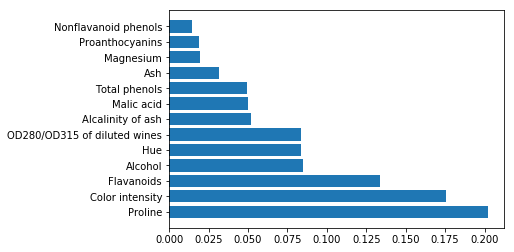

In [153]:
# 重要度をグラフ化
left = np.arange(len(importances))
height = importances['importrances']
label = importances['label']
plt.barh(left, height, tick_label=label)

In [154]:
# 評価1:全項目を対象評価
clf_rf.score(X=X_test, y=y_test)

0.8888888888888888

In [187]:
# 一連の流れを関数化
def randomForestClassifierFitScore(x, y, n_estimators=1000):
    # 学習用とテスト用に分割
    X_tr, X_ts, y_tr, y_ts = train_test_split(x, y, test_size = 0.3)
    # ランダムフォレスト作成
    clf_rf_func = RandomForestClassifier(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    # 学習
    clf_rf_func.fit(X=X_tr, y=y_tr)
    # 評価
    score = clf_rf_func.score(X=X_ts, y=y_ts)
#     print("RandomForestClassifier.score=" + str(score))
    
    # 重要度を確認
    imp = pd.DataFrame(x.columns, columns=['label'])
    imp['importrances'] = clf_rf_func.feature_importances_
    imp = imp.sort_values('importrances', ascending=False)
#     print(imp)
    
    return clf_rf_func, score, imp

In [184]:
# 重要度が低い順に削除していく
import copy
X_tmp = copy.deepcopy(X)
clf_list = []
score_list = []
for item_name in importances['label'].iloc[::-1]:
    # 項目削除
    del X_tmp[item_name]
    if len(X_tmp.columns) == 0:
        break
    print("### del [" + item_name + "] len=" + str(len(X_tmp.columns)) + " ###")
    # 学習と評価
    clf, score, imp = randomForestClassifierFitScore(X_tmp, Y)
    # 結果を保存
    clf_list.append(clf)
    score_list.append(score)
    print("score=" + str(score))

### del [Nonflavanoid phenols] len=12 ###
score=0.8888888888888888
### del [Proanthocyanins] len=11 ###
score=1.0
### del [Magnesium] len=10 ###
score=0.9629629629629629
### del [Ash] len=9 ###
score=0.8888888888888888
### del [Total phenols] len=8 ###
score=0.9259259259259259
### del [Malic acid] len=7 ###
score=1.0
### del [Alcalinity of ash] len=6 ###
score=1.0
### del [OD280/OD315 of diluted wines] len=5 ###
score=0.9629629629629629
### del [Hue] len=4 ###
score=0.9259259259259259
### del [Alcohol] len=3 ###
score=0.9259259259259259
### del [Flavanoids] len=2 ###
score=0.8888888888888888
### del [Color intensity] len=1 ###
score=0.7037037037037037


In [168]:
# Alcalinity of ash　までを削除したモデルを採用してみる
result_clf = clf_list[6]
result_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [163]:
# テスト
df_test = pd.read_csv('test.tsv',delimiter='\t' )
df_test.head()

,id,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,2,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510
1,4,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675
2,5,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630
3,7,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480
4,8,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280


In [165]:
# 特徴変数
test_X = df_test.iloc[:,1:]
test_X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675
2,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630
3,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480
4,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280


In [167]:
# 重要度高めの項目のみを残してデータを作成
for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
    del test_X[l]
test_X.head()

,Alcohol,Flavanoids,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.10,3.32,5.75,1.25,3.17,1510
1,13.23,0.83,10.52,0.56,1.51,675
2,12.08,1.58,2.20,1.31,2.72,630
3,12.08,1.50,2.40,1.08,2.27,480
4,14.30,3.14,6.20,1.07,2.65,1280


In [169]:
# モデルを使用して予測
ans = result_clf.predict(X=test_X)
ans

array([1, 3, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 3, 1, 3, 1, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 3, 1, 3, 3, 1, 2, 2, 3, 2, 3, 2, 3, 3, 2, 1,
       3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 2, 2, 3, 1, 1, 1, 2, 1, 3, 3, 2,
       2], dtype=int64)

In [182]:
# 提出用に加工
np_id = df_test['id'].values
dd=pd.DataFrame({"id":np_id, "ans":ans})
dd.to_csv("result01.csv",header=False,index=False)
dd

,id,ans
0,2,1
1,4,3
2,5,2
3,7,2
4,8,1
5,10,1
6,16,2
7,18,2
8,19,1
9,22,2


#### 結果は"0.96629"でした

In [188]:
# ランダムフォレストの作成木の数を調整してみる　n_estimators
import copy
# 重要度が低い項目は削除したままで
X2_tmp = copy.deepcopy(X)
for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
    del X2_tmp[l]

n_estimators_list = []
clf2_list = []
score2_list = []
# 100から10000までで100単位でn_estimatorsの値を増やしてテスト
for n in range(100, 10000, 100):
    # 学習と評価
    clf, score, imp = randomForestClassifierFitScore(X2_tmp, Y, n_estimators=n)
    # 結果を保存
    n_estimators_list.append(n)
    clf2_list.append(clf)
    score2_list.append(score)
    print("n_estimators=" + str(n) + ", score=" + str(score))

n_estimators=100, score=1.0
n_estimators=200, score=0.7407407407407407
n_estimators=300, score=0.9629629629629629
n_estimators=400, score=1.0
n_estimators=500, score=1.0
n_estimators=600, score=1.0
n_estimators=700, score=0.9629629629629629
n_estimators=800, score=0.8888888888888888
n_estimators=900, score=0.9629629629629629
n_estimators=1000, score=1.0
n_estimators=1100, score=0.9629629629629629
n_estimators=1200, score=1.0
n_estimators=1300, score=0.9259259259259259
n_estimators=1400, score=0.9629629629629629
n_estimators=1500, score=0.9629629629629629
n_estimators=1600, score=0.9259259259259259
n_estimators=1700, score=0.9629629629629629
n_estimators=1800, score=0.9629629629629629
n_estimators=1900, score=0.9629629629629629
n_estimators=2000, score=1.0
n_estimators=2100, score=1.0
n_estimators=2200, score=0.9629629629629629
n_estimators=2300, score=1.0
n_estimators=2400, score=1.0
n_estimators=2500, score=1.0
n_estimators=2600, score=0.9629629629629629
n_estimators=2700, score=0.962

In [189]:
# モデルを使用して予測
result_clf2 = clf2_list[4]
ans2 = result_clf2.predict(X=test_X)
ans2

array([1, 3, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 3, 1, 3, 1, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3, 2, 1,
       3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 3, 2, 3, 2, 1, 2, 3, 1, 1, 2, 2, 3, 1, 1, 1, 2, 1, 3, 3, 2,
       2], dtype=int64)

In [193]:
import collections
diff_list = []
for i in range(len(ans)):
    diff_list.append(int(ans[i])-int(ans2[i]))
collections.Counter(diff_list)

Counter({0: 86, -1: 2, 1: 1})

In [194]:
# 提出用に加工
np_id = df_test['id'].values
dd=pd.DataFrame({"id":np_id, "ans":ans2})
dd.to_csv("result02.csv",header=False,index=False)


#### 結果は"0.97753"でした